# Test Holopy For Chlamys

# Importations & Load Data

## Importations

In [1]:
import numpy as np
import imageio

In [2]:
import os 
import sys
import copy
from tqdm import tqdm

In [3]:
sys.path

['/opt/anaconda3/envs/holopy/lib/python39.zip',
 '/opt/anaconda3/envs/holopy/lib/python3.9',
 '/opt/anaconda3/envs/holopy/lib/python3.9/lib-dynload',
 '',
 '/opt/anaconda3/envs/holopy/lib/python3.9/site-packages']

In [4]:
os.environ["OMP_NUM_THREADS"] = "1"

# os.environ.setdefault("OMPI_MCA_opal_cuda_support","true")
os.environ["OMPI_MCA_opal_cuda_support"] = "true" 

In [5]:
# Holopy
import holopy as hp
# Utilities
from holopy.core.io import load_average
from holopy.core.process import bg_correct, subimage, normalize, center_find
# Define Scatterers
from holopy.scattering import Sphere, Spheres, Cylinder
from holopy.scattering.scatterer import Spheroid
from holopy.scattering.scatterer import Capsule
# Theories
from holopy.scattering import Mie
from holopy.scattering.theory import Tmatrix, DDA
# Compute holograms and fit
from holopy.scattering import calc_holo
from holopy.inference import CmaStrategy
from holopy.inference import prior, ExactModel, NmpfitStrategy

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
from matplotlib import rc
import matplotlib.colors as mplcolors
from mpltools import annotation

rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=0.5)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)

rc('font', family='serif', size=9)
rc('text', usetex=True)

rc('figure', dpi=200)
rc('savefig', dpi=600)

In [7]:
import platform
print(platform.architecture())

('64bit', 'ELF')


## Load Data

In [8]:
# Load an experimental video 
# vid_path = '/home/n.fares/DOCTORAT/analysis_chlamys/stage_elorri/data/20240702/2/Basler_acA1920-155um__22392621__20240702_152120657_trimmed_from_7250_s_to_8750_s.mp4'
# vid = imageio.get_reader(vid_path)

# Auxiliary Functions

In [9]:
# Adapted from pylorenzmie

def aziavgstd(data, center):
    '''Azimuthal average and standard deviation of data about center
    
    Parameters
    ----------
    data : array_like
        image data
    center : tuple
        (x_p, y_p) center of azimuthal average

    Returns
    -------
    avg : array_like
        One-dimensional azimuthal average of data about center
    std : array_like
        Standard deviation from the mean
    '''
    x_p, y_p = center
    ny, nx, _ = data.shape
    x = np.arange(nx) - x_p
    y = np.arange(ny) - y_p
    
    d = data.ravel()
    r = np.hypot.outer(y, x).astype(int).ravel()
    nr = np.bincount(r)
    avg = np.bincount(r, d) / nr
    std = np.sqrt(np.bincount(r, (d - avg[r])**2) / nr)
    rad = np.arange(len(avg))
    return rad, avg, std

# ADDA

In [10]:
# Choose a method 
# Either 'seq', 'mpi', or 'ocl'
method = 'mpi'

# Not coded yet, factice choice

In [11]:
# Remove adda methods already in path

# sys.path controls paths for python
# os.environ['PATH'] controls machine paths (.bashrc file)

# Get all the paths in a list
paths = os.environ['PATH'].split(':') 
# Loop over the elements but knowing that the list paths will change
for i, path in enumerate(os.environ['PATH'].split(':')): 
    if 'adda' in path: 
        paths.remove(path)
# Recombine the paths
os.environ['PATH'] = ":".join(paths)

# while 'adda' in os.environ["PATH"]:
#     os.environ['PATH'] = ":".join(os.environ["PATH"].split(":")[:-1])

print(os.environ['PATH'])

/opt/anaconda3/envs/holopy/bin:/opt/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/opt/anaconda3/bin:/opt/pylon/bin:/usr/local/cuda-12.9/bin:/snap/bin


In [12]:
# Add adda to path
os.environ['PATH'] += ''.join([':/home/n.fares/adda/src/', 'seq'])
os.environ['PATH'] += ''.join([':/home/n.fares/adda/src/', 'mpi'])
os.environ['PATH'] += ''.join([':/home/n.fares/adda/src/', 'ocl'])

In [13]:
print(os.environ["PATH"])

/opt/anaconda3/envs/holopy/bin:/opt/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/opt/anaconda3/bin:/opt/pylon/bin:/usr/local/cuda-12.9/bin:/snap/bin:/home/n.fares/adda/src/seq:/home/n.fares/adda/src/mpi:/home/n.fares/adda/src/ocl


# Compute Objects

In [15]:
# Some global variables

illum_polarization = (1, 0)

## Cylinder

### Tmatrix

In [15]:
%%time

spacing = 0.05799
medium_index = 1.33
illum_wavelen = 0.532
h = 300 # px

detector = hp.detector_grid(shape=h, spacing=spacing)

theory = Tmatrix()

c = Cylinder(center=(h//2*spacing, h//4*spacing, 7), n = 1.59, d=0.5, h=1, rotation=(0., np.pi/2, 2*np.pi/3))

holo = calc_holo(
    detector, c, 
    medium_index, illum_wavelen, illum_polarization, 
    theory=theory, 
)

CPU times: user 4.22 s, sys: 6.36 ms, total: 4.23 s
Wall time: 4.25 s


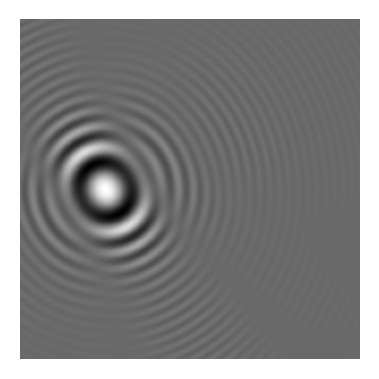

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54,5/2.54))

ax.imshow(holo, cmap='gray')

ax.axis('off')

plt.tight_layout()
plt.show()

## Spherocylinder

### Compute an image with DDA

In [16]:
%%time

spacing = 0.05799
medium_index = 1.33
illum_wavelen = 0.532
h = 300 # px

detector = hp.detector_grid(shape=h, spacing=spacing)

from holopy.scattering.theory.dda import DDA

theory = DDA(n_cpu=1, use_gpu=True)

scatterer = Capsule(center=(h//2*spacing, h//2*spacing, 15), n = 1.40, d=0.2, h=1, rotation=(np.pi/4, np.pi/4, 0.))

holo = calc_holo(
    detector, 
    scatterer, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory, 
)

CPU times: user 651 ms, sys: 285 ms, total: 936 ms
Wall time: 1.27 s


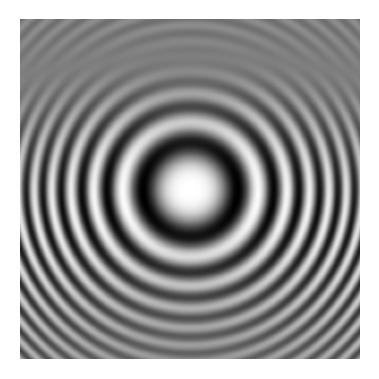

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54,5/2.54))

ax.imshow(holo, cmap='gray')

ax.axis('off')

plt.tight_layout()
plt.show()

# Fit Theoretical Images

### Fit an image, with DDA or not

In [18]:
# Choose a hologram 

In [19]:
hc = 300
xc, yc = hc//2, hc//2

# holo_c = copy.deepcopy(holo)

# Crop
holo_c = subimage(holo, [h//2,h//2], hc)
# holo_c = copy.deepcopy(holo)
holo_c = normalize(holo_c)

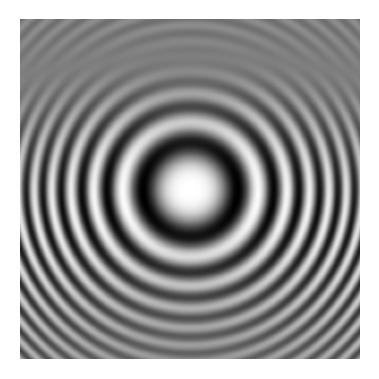

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54,5/2.54))

ax.imshow(holo_c, cmap='gray')

ax.axis('off')

plt.tight_layout()
plt.show()

In [21]:
# Parameters you want to fit are defined as prior guesses 
x_p = hc//2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=yc*spacing)
y_p = hc//2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=xc*spacing)
z_p = prior.Uniform(lower_bound=14, upper_bound=16, guess=14.2)
h_p = 1 #prior.Uniform(4.1, 4.3, 4.2)
d_p = 0.2 #prior.Uniform(0, 0.5, 0.2)
n_p = 1.40 #prior.Uniform(1.39, 1.41, 1.40)
theta1 = np.pi / 4
theta2 = np.pi / 4
theta3 = 0.

# Define the scatterer
par_scatterer = Capsule(center=(x_p, y_p, z_p), n=n_p, d=d_p, h=h_p, rotation=(theta1, theta2, theta3))

In [22]:
%%time 

# Basic fit

# Define the theory
theory = DDA(use_gpu=True) #'auto' #DDA(n_cpu=1, use_gpu=False)

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )
# noise_sd can be set to None if all the prior variables are Uniform(). 
# Otherwise noise_sd must be set to something...
# ExactModel does not include alpha 
# If you want alpha: AlphaModel()

# model._parameter_names = ['r', 'x', 'y', 'z']

# Define the fit strategy
fit_strategy = NmpfitStrategy()
fit_strategy.npixels = int(0.5 * hc ** 2)
fit_strategy.ftol = 1e-8
fit_strategy.xtol = 1e-8
fit_strategy.gtol = 1e-8

# Fit 
fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 
# Parameters to fit are included in the model through the prior objects. 

print(fit_result.parameters)

{'center.2': 14.836911618663834}
CPU times: user 28.6 s, sys: 19.4 s, total: 48 s
Wall time: 57.3 s


In [23]:
model.illum_wavelen

0.532

In [24]:
%%time 

# CMA fit

# Define the theory
theory = DDA(use_gpu=False) #'auto' #DDA(n_cpu=1, use_gpu=False)

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    ) 
# noise_sd can be set to None if all the prior variables are Uniform(). 
# Otherwise noise_sd must be set to something...
# ExactModel does not include alpha 
# If you want alpha: AlphaModel()

# model._parameter_names = ['r', 'x', 'y', 'z']

# Define the fit strategy
fit_strategy = CmaStrategy(popsize=50)
fit_strategy.npixels = int(0.5 * hc ** 2)
fit_strategy.resample_pixels = True
fit_strategy.parallel = 20 #'mpi'
fit_strategy.seed = 1000

# Fit 
fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 
# Parameters to fit are included in the model through the prior objects. 

print(fit_result.parameters)

{'center.2': 15.000845215050738}
CPU times: user 230 ms, sys: 197 ms, total: 426 ms
Wall time: 14.9 s


In [25]:
holo_f = fit_result.hologram

{'center.2': 15.000845215050738}


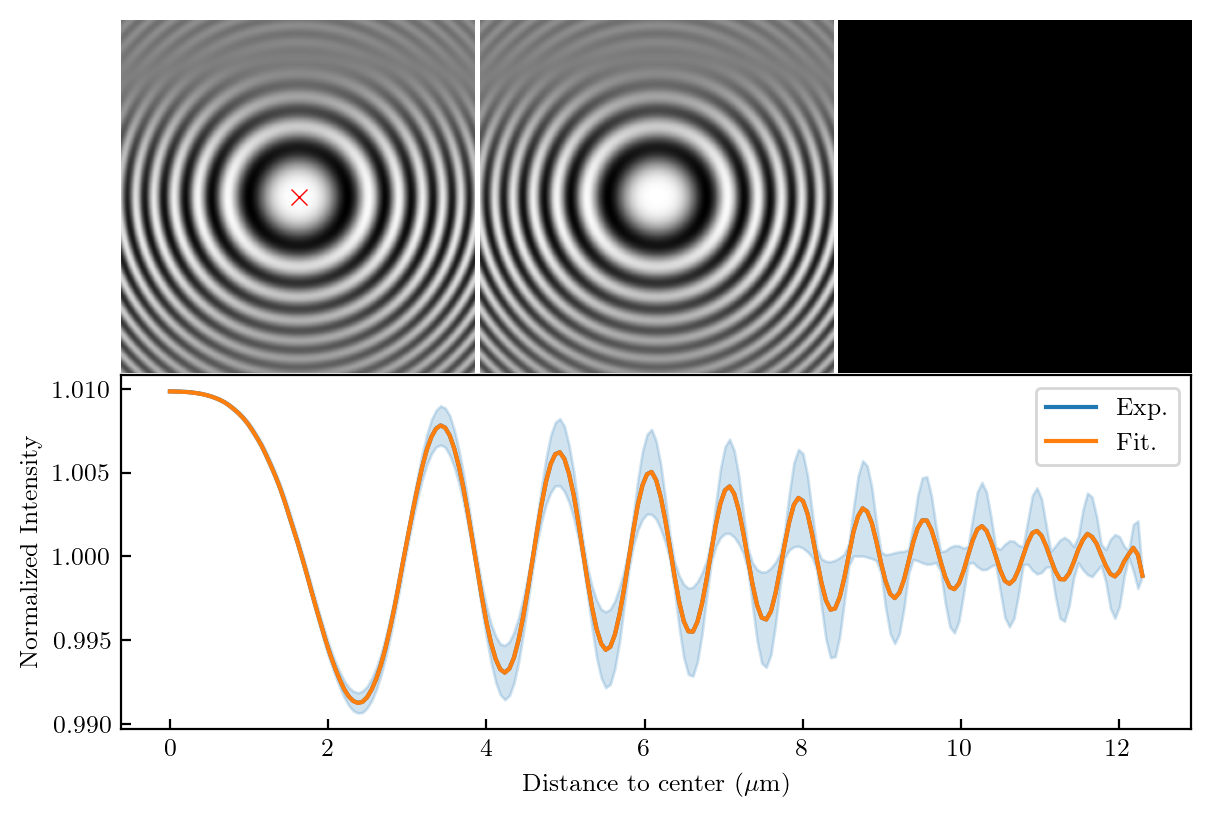

In [26]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [27]:
%%time 

# Parameters you want to fit are defined as prior guesses 
x_p = hc//2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=yc*spacing)
y_p = hc//2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=xc*spacing)
z_p = prior.Uniform(lower_bound=14, upper_bound=16, guess=14.2)
h_p = prior.Uniform(0.5, 1.5, 0.9)
d_p = prior.Uniform(0, 0.5, 0.2)
n_p = prior.Uniform(1.39, 1.41, 1.40)
theta1 = np.pi / 4
theta2 = np.pi / 4
theta3 = 0.

# Define the scatterer
par_scatterer = Capsule(center=(x_p, y_p, z_p), n=n_p, d=d_p, h=h_p, rotation=(theta1, theta2, theta3))

# CMA fit

# Define the theory
theory = DDA(use_gpu=False) #'auto' #DDA(n_cpu=1, use_gpu=False)

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )
# noise_sd can be set to None if all the prior variables are Uniform(). 
# Otherwise noise_sd must be set to something...
# ExactModel does not include alpha 
# If you want alpha: AlphaModel()

# model._parameter_names = ['r', 'x', 'y', 'z']

# Define the fit strategy
fit_strategy = CmaStrategy(popsize=50)
fit_strategy.npixels = int(0.5 * hc ** 2)
fit_strategy.resample_pixels = True
fit_strategy.parallel = 20 #'mpi'
fit_strategy.seed = 1000

# Fit 
# fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 

# print(fit_result.parameters)


# Commented because leads to CalledProcessError

CPU times: user 648 µs, sys: 8.51 ms, total: 9.16 ms
Wall time: 12.4 ms


In [28]:
# holo_f = fit_result.hologram

In [29]:
# print(fit_result.parameters)

# fig = plt.figure(figsize=(15/2.54,10/2.54))
# nlin, ncol = 2, 3

# # Plot images
# ax1 = fig.add_subplot(nlin, ncol, 1)
# ax2 = fig.add_subplot(nlin, ncol, 2)
# ax3 = fig.add_subplot(nlin, ncol, 3)
# ax1.imshow(holo_c.data, cmap='gray')
# ax2.imshow(holo_f, cmap='gray')
# ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
# for ax in [ax1, ax2, ax3]:
#     ax.axis('off')

# # Compute radial intensity profiles 
# expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
# theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
# expe_rad = expe_rad * spacing 
# theo_rad = theo_rad * spacing 

# ax1.plot(hc//2, hc//2, marker='x', mec='r')

# # Plot radial intensity profile
# ax4 = fig.add_subplot(nlin, ncol, (4,6))
# ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
# ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
# ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
# ax4.legend()
# ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
# plt.tight_layout(pad=0.2)
# plt.show()

## Spheroid

In [28]:
%%time

spacing = 0.05799
medium_index = 1.33
illum_wavelen = 0.532
h = 200 # px

detector = hp.detector_grid(shape=h, spacing=spacing)

a_p = 1
da_p = - 0.5
n_p = 1.4

theory = Tmatrix() #DDA(n_cpu=1, use_gpu=False)

spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(h//2*spacing, h//2*spacing, 15), rotation=(2, 2, np.pi/4))

holo = calc_holo(
    detector, spheroid, 
    medium_index, illum_wavelen, illum_polarization, 
    theory=theory, 
)

CPU times: user 2.39 s, sys: 6.12 ms, total: 2.4 s
Wall time: 2.39 s


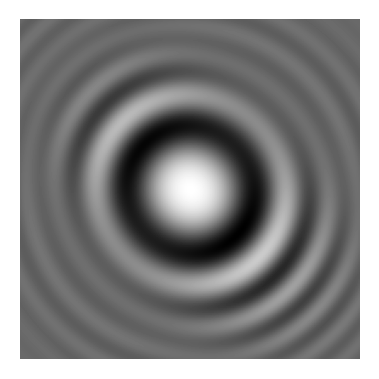

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54,5/2.54))

ax.imshow(holo, cmap='gray')

ax.axis('off')

plt.tight_layout()
plt.show()

In [30]:
hc = 200
xc, yc = hc//2, hc//2

# holo_c = copy.deepcopy(holo)

# Crop
holo_c = subimage(holo, [h//2,h//2], hc)
# holo_c = copy.deepcopy(holo)
holo_c = normalize(holo_c)

In [31]:
# /!\ WARNING: Below for guesses, h must be modified to hc /!\

In [40]:
%%time 

# Fitting ``by hand'', CMA-es fit strategy

# Parameters you want to fit are defined as prior guesses 
x_p = h/2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=yc*spacing)
y_p = h/2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=xc*spacing)
z_p = prior.Uniform(lower_bound=14, upper_bound=16, guess=14.2)
a_p = prior.Uniform(0.5, 1.5, 1.2)
da_p = prior.Uniform(-1, 1, -0.3)
n_p = prior.Uniform(1.37, 1.43, 1.39)
theta1 = 2
theta2 = 2
theta3 = np.pi/4

# Define the scatterer
par_scatterer = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))

# Define the theory
theory = DDA(n_cpu=1) #'auto' #DDA(n_cpu=1, use_gpu=False)

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )
# noise_sd can be set to None if all the prior variables are Uniform(). 
# Otherwise noise_sd must be set to something...
# ExactModel does not include alpha 
# If you want alpha: AlphaModel()

# model._parameter_names = ['r', 'x', 'y', 'z']

# Define the fit strategy
fit_strategy = CmaStrategy(popsize=50, parallel=10)
fit_strategy.npixels = int(0.2 * hc ** 2)
fit_strategy.resample_pixels = True
fit_strategy.parallel = 20 #'mpi'
fit_strategy.seed = 1000

# Fit 
fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 
# Parameters to fit are included in the model through the prior objects. 

print(fit_result.parameters)

{'n': 1.3998478528759415, 'r.0': 0.9890610025324107, 'r.1.1': -0.48514147610425323, 'center.2': 14.968115387569865}
CPU times: user 1.72 s, sys: 2.56 s, total: 4.28 s
Wall time: 7min 39s


In [41]:
holo_f = fit_result.hologram

{'n': 1.3998478528759415, 'r.0': 0.9890610025324107, 'r.1.1': -0.48514147610425323, 'center.2': 14.968115387569865}


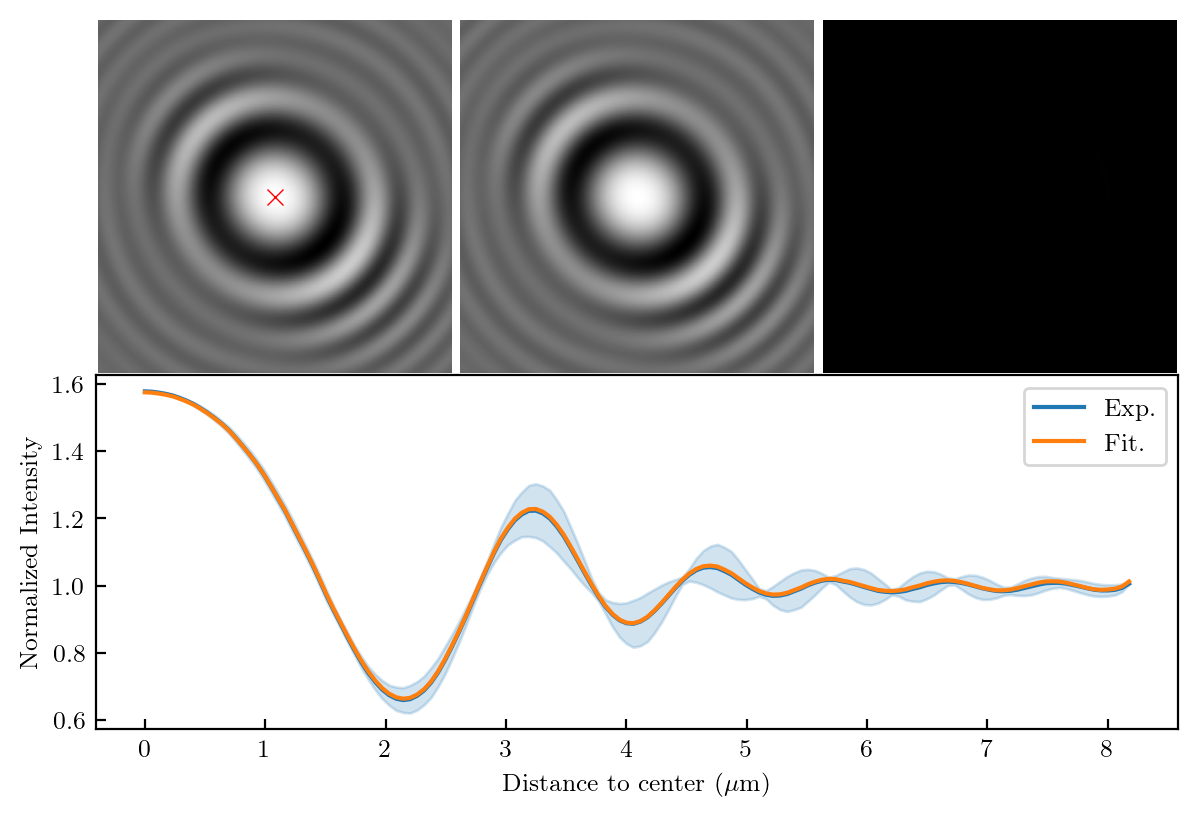

In [42]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [ ]:
# %%time 

# Cell not run anymore, just here for souvenir

# Parameters you want to fit are defined as prior guesses 
x_p = h/2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=yc*spacing)
y_p = h/2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=xc*spacing)
z_p = prior.Uniform(lower_bound=14, upper_bound=16, guess=14.2)
a_p = prior.Uniform(0.5, 1.5, 1.2)
da_p = prior.Uniform(-1, 1, -0.3)
n_p = prior.Uniform(1.37, 1.43, 1.39)
theta1 = 2
theta2 = 2
theta3 = np.pi/4

# Define the scatterer
par_scatterer = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))

# Define the theory
theory = DDA(use_gpu=True) #'auto' #DDA(n_cpu=1, use_gpu=False)

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )

# Define the fit strategy
fit_strategy = CmaStrategy(popsize=50)
fit_strategy.npixels = int(0.2 * hc ** 2)
fit_strategy.resample_pixels = True
fit_strategy.parallel = 20 #'mpi'
fit_strategy.seed = 1000

# Fit 
# fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 
# Parameters to fit are included in the model through the prior objects. 

# print(fit_result.parameters)


print('Running the fit gave:')
print("{'n': 1.3998478528759415, 'r.0': 0.9890610025324107, 'r.1.1': -0.48514147610425323, 'center.2': 14.968115387569865}")
print("CPU times: user 1.78 s, sys: 2.65 s, total: 4.43 s")
print("Wall time: 7min 54s")

Running the fit gave:
{'n': 1.3998478528759415, 'r.0': 0.9890610025324107, 'r.1.1': -0.48514147610425323, 'center.2': 14.968115387569865}
CPU times: user 1.78 s, sys: 2.65 s, total: 4.43 s
Wall time: 7min 54s


In [ ]:
%%time

# Fitting ``by hand'', LM fit strategy

# It is faster, but innacurate for now.
# Innacuracy may explain why it is faster.

# Parameters you want to fit are defined as prior guesses 
x_p = hc/2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=yc*spacing)
y_p = hc/2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=xc*spacing)
z_p = prior.Uniform(lower_bound=14, upper_bound=16, guess=14.2)
a_p = prior.Uniform(0.5, 1.5, 1.2)
da_p = prior.Uniform(-1, 1, -0.3)
n_p = prior.Uniform(1.37, 1.43, 1.39)
theta1 = 2
theta2 = 2
theta3 = np.pi/4

# Define the scatterer
par_scatterer = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))

# Define the theory
theory = 'auto' #DDA(n_cpu=1, use_gpu=False)

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )
# noise_sd can be set to None if all the prior variables are Uniform(). 
# Otherwise noise_sd must be set to something...
# ExactModel does not include alpha 
# If you want alpha: AlphaModel()

# model._parameter_names = ['r', 'x', 'y', 'z']

# Define the fit strategy
fit_strategy = NmpfitStrategy()
fit_strategy.npixels = int(0.4 * hc** 2)
# fit_strategy.ftol = 1e-8
# fit_strategy.xtol = 1e-8
# fit_strategy.gtol = 1e-8

# Fit 
fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 
# Parameters to fit are included in the model through the prior objects. 

print(fit_result.parameters)

{'n': 1.3834232101495805, 'r.0': 1.1543727083089539, 'r.1.1': -0.3275101777607627, 'center.2': 14.0}
CPU times: user 21.3 s, sys: 0 ns, total: 21.3 s
Wall time: 21.2 s


In [34]:
holo_f = fit_result.hologram

{'n': 1.3834232101495805, 'r.0': 1.1543727083089539, 'r.1.1': -0.3275101777607627, 'center.2': 14.0}


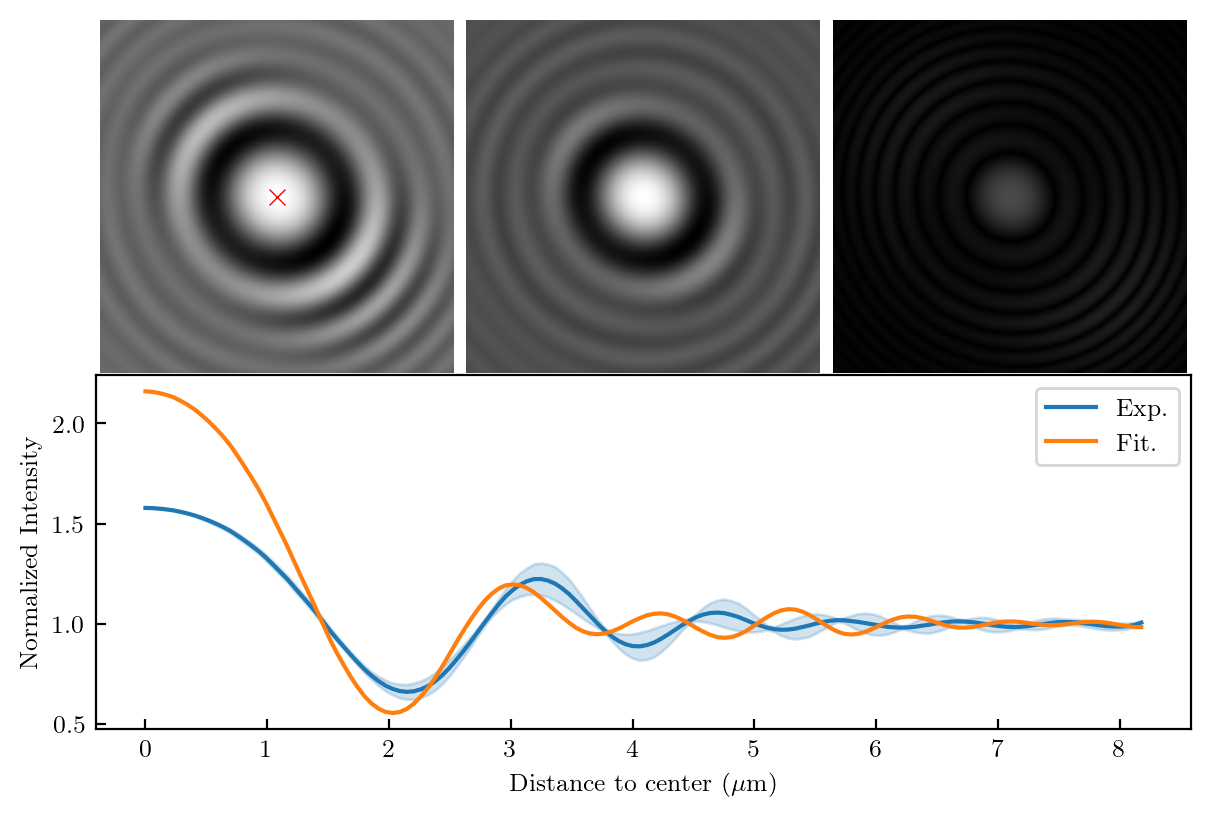

In [35]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [36]:
# hp.save('image_bis', holo_c)
# hp.save('image_bis_fitted', holo_f)

In [37]:
holo_c = hp.load('image_bis.h5')
holo_f = hp.load('image_bis_fitted.h5')

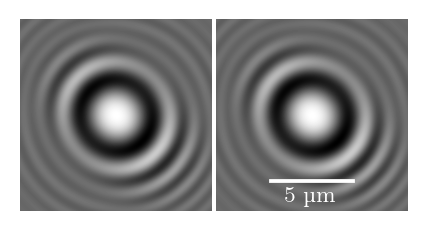

In [38]:
fig = plt.figure(figsize=(5/2.54,2.5/2.54))
nlin, ncol = 1, 2

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
# ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
# ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
# for ax in [ax1, ax2, ax3]:
for ax in [ax1, ax2]:
    ax.axis('off')

scalebar = AnchoredSizeBar(ax2.transData,
                           5/spacing, "5 µm", 'lower center', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fm.FontProperties(size=8)
                          )
ax2.add_artist(scalebar)

plt.tight_layout(pad=0.1)
plt.show()

In [39]:
# fig.savefig('fit_spheroid_a1_1um_a2_500nm_z_expected_15um_bis.pdf')

# Spheroid, Not by Hand

In [57]:
# Compute a Spheroid 

spacing = 0.05799
medium_index = 1.33
illum_wavelen = 0.532
h = 200 # px

detector = hp.detector_grid(shape=h, spacing=spacing)

a_p = 1
da_p = - 0.5
n_p = 1.4

theta1 = 2
theta2 = 2
theta3 = np.pi / 4

theory = Tmatrix() #DDA(n_cpu=1, use_gpu=False)

spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(h//2*spacing, h//2*spacing, 15), rotation=(theta1, theta2, theta3))

holo = calc_holo(
    detector, spheroid, 
    medium_index, illum_wavelen, illum_polarization, 
    theory=theory, 
)

In [58]:
# Crop 

hc = 200
xc, yc = h//2, h//2

# holo_c = copy.deepcopy(holo)

# Crop
holo_c = subimage(holo, [h//2,h//2], hc)
# holo_c = copy.deepcopy(holo)
holo_c = normalize(holo_c)

In [59]:
guess_scatterer = Spheroid(n=1.39, r=(1.1, 0.8), center=(x_p, y_p, 14.2), rotation=(theta1+10/180*np.pi, theta2-10/180*np.pi, theta3+20/180*np.pi))

In [65]:


# Define the fitting strategy

percent_px = 0.3

fit_strategy = NmpfitStrategy()
fit_strategy.npixels = int(percent_px * hc ** 2)



In [66]:
# Which parameters 
parameters_to_fit = ['center', 'r', 'n', 'rotation']

In [67]:
%%time 

# Fit
fit_result = hp.fit(holo_c, guess_scatterer, strategy=fit_strategy, parameters=parameters_to_fit)

CPU times: user 2min 36s, sys: 0 ns, total: 2min 36s
Wall time: 2min 36s


In [68]:
holo_f = fit_result.hologram

{'n': 1.4008555025887344, 'r.0': 1.0009658144417286, 'r.1': 0.500292666482675, 'rotation.0': 2.1278075271058206, 'rotation.1': 2.0031876077101756, 'rotation.2': 0.7851639598374845, 'x': 5.798978635937567, 'y': 5.799025724651989, 'z': 15.016893482232948, 'alpha': 0.9845254407643746}


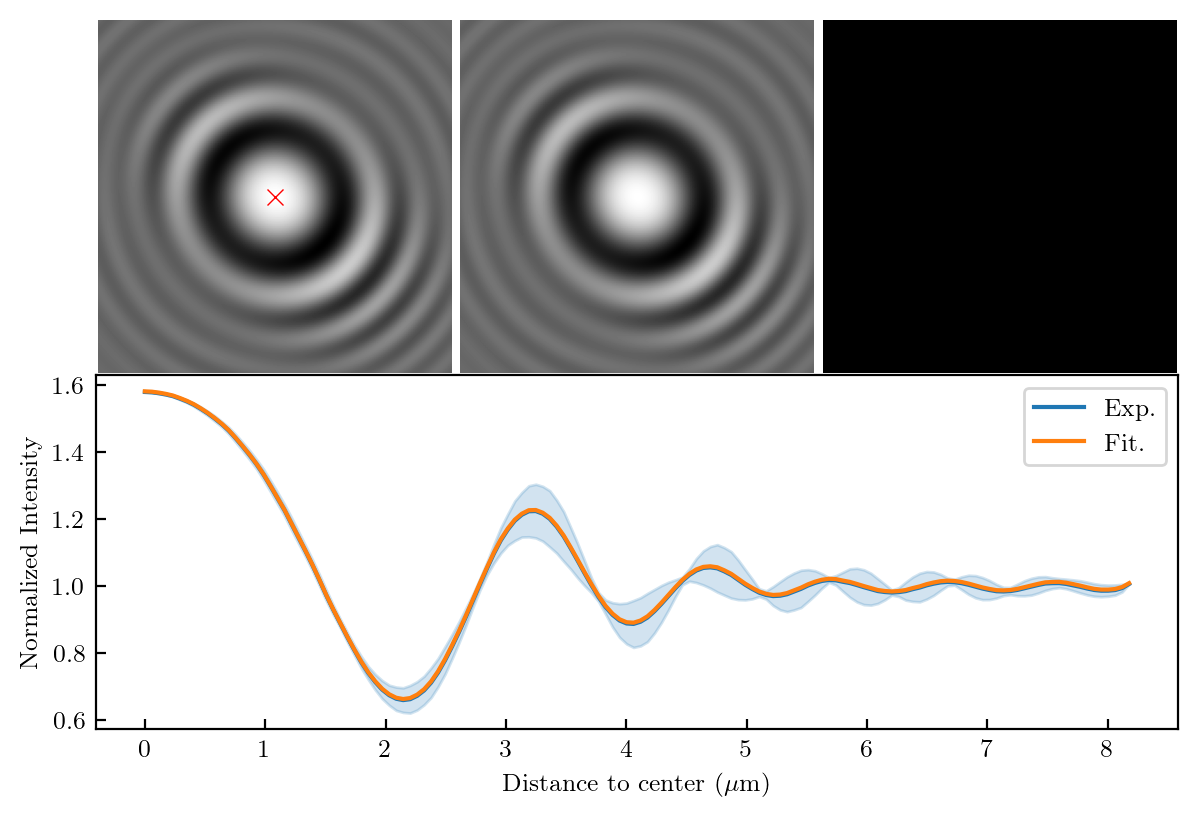

In [69]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [ ]:
# fig.savefig('fit_theoretical_spheroid_all.pdf')

# Test Compute Hologram

In [ ]:
# For know, I stopped at the computation of the Mueller matrix and S-matrix. 
# See holopy codes to propagate...

In [70]:
# %%time

# spacing = 0.05799
# medium_index = 1.33
# illum_wavelen = 0.532
# h = 200 # px

# detector = hp.detector_grid(shape=h, spacing=spacing)

# a_p = 1
# da_p = - 0.5
# n_p = 1.4

# theory = DDA(use_gpu=True) #DDA(n_cpu=1, use_gpu=False)

# spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(h//2*spacing, h//2*spacing, 15), rotation=(2, 2, np.pi/4))

# holo = calc_holo(
#     detector, spheroid, 
#     medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
#     theory=theory, 
# )

In [71]:
# holo.illum_wavelen

In [72]:
# %%time

# spacing = 0.05799
# medium_index = 1.33
# illum_wavelen = 0.532
# h = 200 # px

# detector = hp.detector_grid(shape=h, spacing=spacing)

# a_p = 1
# da_p = - 0.5
# n_p = 1.4

# theory = DDA(n_cpu=10, use_gpu=False)

# spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(h//2*spacing, h//2*spacing, 15), rotation=(2, 2, np.pi/4))

# holo = calc_holo(
#     detector, spheroid, 
#     medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
#     theory=theory, 
# )

In [73]:
# !adda_ocl -lambda 0.532 -m 1.4 0 -grid 30 -size 3.5 -shape ellipsoid 1 1.3 -orient 1 2 0 

# Fit Noisy Theoretical Images 

In [17]:
%%time

# Compute a Spheroid 

spacing = 0.05799
medium_index = 1.33
illum_wavelen = 0.532
h = 200 # px

detector = hp.detector_grid(shape=h, spacing=spacing)

a_p = 1
da_p = - 0.2
n_p = 1.4

x_p = h//2*spacing
y_p = h//2*spacing
z_p = 15

theta1 = 5 * np.pi / 180
theta2 = 1
theta3 = 0

theory = Tmatrix() #DDA(n_cpu=1, use_gpu=False)

spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))

holo_ideal = calc_holo(
    detector=detector, scatterer=spheroid, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory, 
)

CPU times: user 3.26 s, sys: 745 µs, total: 3.26 s
Wall time: 3.24 s


In [18]:
# Noise the hologram 

noise = np.random.normal(loc=0.0, scale=np.std(holo_ideal.data)/2, size=np.shape(holo_ideal.data))

holo = copy.deepcopy(holo_ideal)
holo.data = holo_ideal + noise 

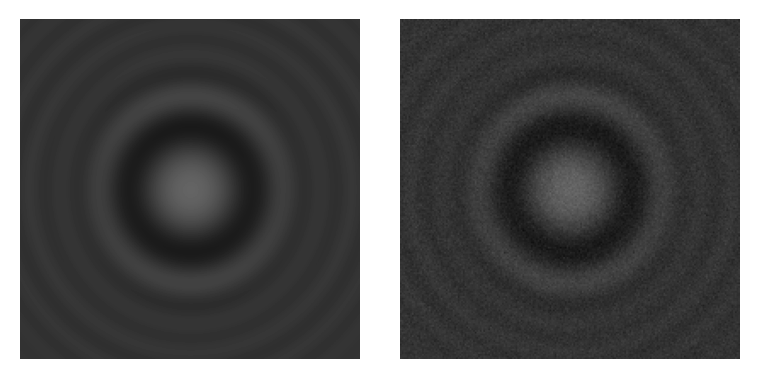

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10/2.54, 5/2.54))

vmin, vmax = 0, 5

axes[0].imshow(holo_ideal.data, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].imshow(holo.data, cmap='gray', vmin=vmin, vmax=vmax)

for i in range(len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [20]:
# Crop 

hc = 200
xc, yc = h//2, h//2

# holo_c = copy.deepcopy(holo)

# Crop
holo_c = subimage(holo, [h//2,h//2], hc)
# holo_c = copy.deepcopy(holo)
holo_c = normalize(holo_c)

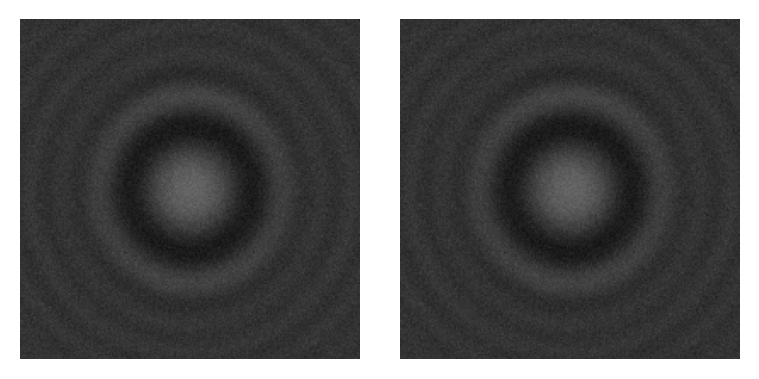

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10/2.54, 5/2.54))

vmin, vmax = 0, 5

axes[0].imshow(holo.data, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].imshow(holo_c.data, cmap='gray', vmin=vmin, vmax=vmax)

for i in range(len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [22]:
# Guess 

guess_scatterer = Spheroid(n=n_p-0.01, r=(a_p + 0.2, a_p + da_p - 0.1), center=(x_p, y_p, z_p), rotation=(theta1+3/180*np.pi, theta2-10/180*np.pi, theta3+1/180*np.pi))

In [23]:
# Define the fitting strategy

percent_px = 0.2

fit_strategy = NmpfitStrategy()
fit_strategy.npixels = int(percent_px * hc ** 2)

# fit_strategy = CmaStrategy(popsize=50, parallel=None)
# fit_strategy.npixels = int(percent_px * hc ** 2)
# fit_strategy.resample_pixels = True
# fit_strategy.parallel = 10 #'mpi'
# fit_strategy.seed = 1000

In [24]:
# Which parameters 
parameters_to_fit = ['center', 'r', 'n', 'rotation']

In [25]:
%%time 

# Fit
fit_result = hp.fit(holo_c, guess_scatterer, strategy=fit_strategy, parameters=parameters_to_fit)

: 

In [23]:
holo_f = fit_result.hologram

{'n': 1.326339208163987, 'r.0': 1.2066700926320975, 'r.1': 0.39806791254398805, 'rotation.0': 0.1210467955887487, 'rotation.1': 0.3814159909786941, 'rotation.2': 0.5034912207238441, 'x': 5.698762560617523, 'y': 5.658502158651178, 'z': 15.662610049140211, 'alpha': 0.5}


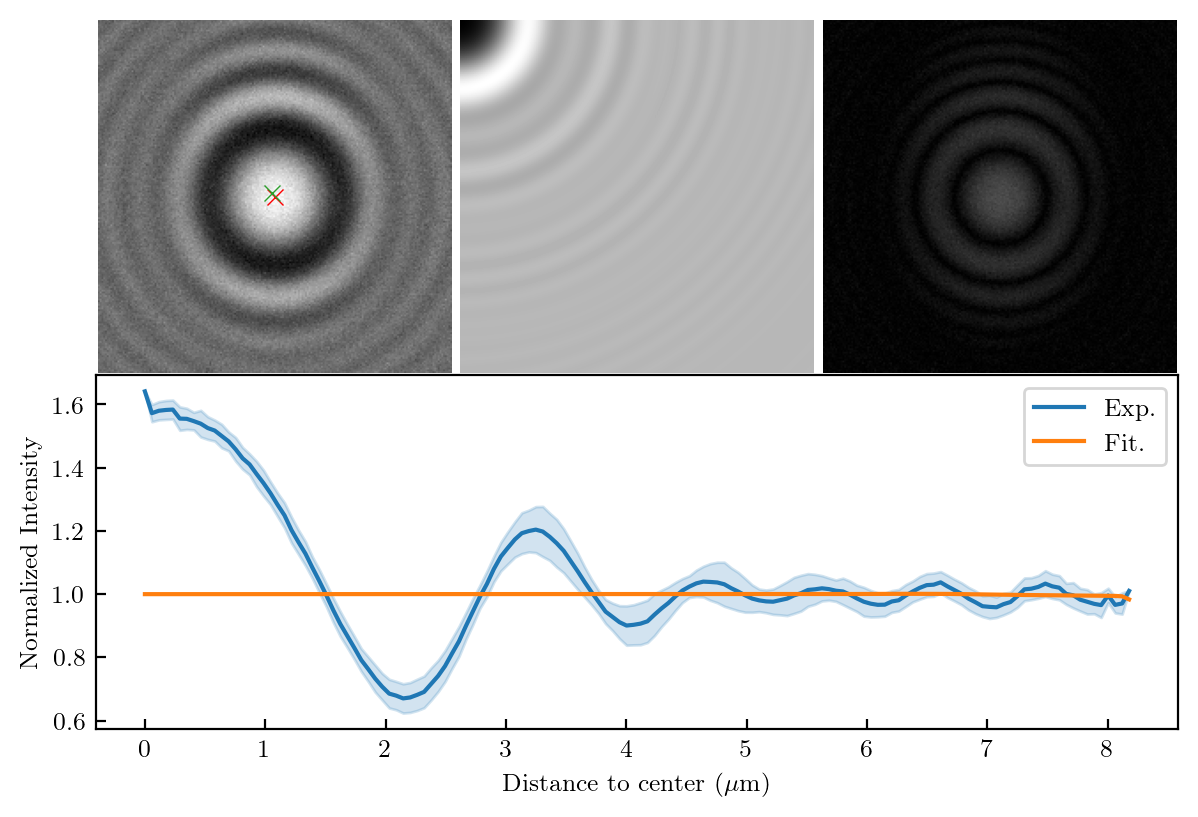

In [24]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')
ax1.plot(fit_result.parameters['x'] / spacing, fit_result.parameters['y'] / spacing, 'x', mec='tab:green')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [34]:
# fig.savefig('fit_all_parameters_spheroid_a1_1um_a2_0p5um_noisy_one_std.pdf')

In [35]:
print(theta1)
print(theta2)
print(theta3)

0.08726646259971647
1
0


In [36]:
fit_result.parameters

{'n': 1.4163669528464582,
 'r.0': 1.0023351127458748,
 'r.1': 0.4235989894726133,
 'rotation.0': 0.14855386507608512,
 'rotation.1': 0.9132978740978263,
 'rotation.2': 0.013470124018484922,
 'x': 5.799103037551434,
 'y': 5.7992161838793255,
 'z': 15.063580646718286,
 'alpha': 0.9727844395737173}

In [33]:
0.05 * 180 / np.pi

2.864788975654116

In [20]:
theory = DDA(n_cpu=10, use_gpu=False)

spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))

holo_ideal = calc_holo(
    detector=detector, scatterer=spheroid, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory, 
)

CalledProcessError: Command '['mpiexec', '-n', '10', 'adda_mpi', '-scat_matr', 'ampl', '-store_scat_grid', '-lambda', '0.4', '-save_geom', '-shape', 'read', '/tmp/tmplqxyj4vf/tmp2qpbv94x', '-dpl', '10.526315789473683', '-m', '1.0526315789473684', '0.0']' returned non-zero exit status 139.

In [36]:
cmd = ['mpiexec', '-n', '10', 'adda_mpi', '-scat_matr', 'ampl', '-store_scat_grid', '-lambda', '0.4', '-save_geom', '-shape', 'read', '/tmp/tmpe8sluatx/tmpg3lx01gz', '-dpl', '10.526315789473683', '-m', '1.0526315789473684', '0.0']

In [37]:
import subprocess

In [38]:
%%time 
result = subprocess.run(cmd, shell=True, capture_output=True, text=True) 

CPU times: user 2.37 ms, sys: 6.16 ms, total: 8.52 ms
Wall time: 21 ms


In [39]:
result

CompletedProcess(args=['mpiexec', '-n', '10', 'adda_mpi', '-scat_matr', 'ampl', '-store_scat_grid', '-lambda', '0.4', '-save_geom', '-shape', 'read', '/tmp/tmpe8sluatx/tmpg3lx01gz', '-dpl', '10.526315789473683', '-m', '1.0526315789473684', '0.0'], returncode=0, stdout='', stderr='--------------------------------------------------------------------------\nNo executable was specified on the prterun command line.\n\nAborting.\n--------------------------------------------------------------------------\n')